<a href="https://colab.research.google.com/github/Meta-user-byte/ISIT-Hack/blob/main/Signal_and_VQC_construction_with_and_without_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install qiskit==0.39.0
!pip install --upgrade pip wheel
!pip install qiskit-aer==0.10.4


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 59.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached qiskit-aer-0.11.0.tar.gz (6.5 MB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
  Using cached qiskit-aer-0.10.4.tar.gz (6.5 MB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Ge

In [26]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [pennylane]


In [43]:
!pip install pennylane-qiskit

  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 64.6 MB/s eta 0:00:00
Using cached requests-2.32.4-py3-none-any.whl (64 kB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
  Attempting uninstall: qiskit
    Found existing installation: qiskit 2.1.0
    Uninstalling qiskit-2.1.0:
      Successfully uninstalled qiskit-2.1.0
  Attempting uninstall: q

In [27]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from qiskit_aer import AerSimulator
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_aer.primitives import EstimatorV2
#from qiskit.algorithms.optimizers import COBYLA
from scipy.optimize import minimize
import pennylane as qml
from qiskit_aer.noise import NoiseModel, depolarizing_error

def generate_signals(n_samples=200, n_points=8):
    """
    Generates a synthetic dataset of sine vs. square waves.

    Args:
        n_samples (int): Total number of signal samples to generate.
        n_points (int): Number of time points to sample for each signal. This
                        will correspond to the number of features/qubits.

    Returns:
        tuple: A tuple containing the signal data (X) and labels (y).
    """
    X = []
    y = []
    t = np.linspace(0, 1, n_points)

    for _ in range(n_samples):
        # Randomly choose between class 0 (sine) and class 1 (square)
        if np.random.rand() < 0.5:
            # Class 0: Sine wave with random frequency and noise
            freq = np.random.uniform(1, 5)
            sig = np.sin(2 * np.pi * freq * t) + 0.1 * np.random.randn(n_points)
            label = 0
        else:
            # Class 1: Square wave with random frequency and noise
            freq = np.random.uniform(1, 5)
            sig = np.sign(np.sin(2 * np.pi * freq * t)) + 0.1 * np.random.randn(n_points)
            label = 1
        X.append(sig)
        y.append(label)

    X = np.array(X)
    y = np.array(y)
    return X, y

# --- 1. Data Generation and Preprocessing ---
print("Step 1: Generating and preprocessing data...")
# Use n_points=8, which means we will need 8 qubits.
X, y = generate_signals(n_samples=200, n_points=8)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)
print(f"Data prepared: {X_train.shape} training samples, {X_test.shape} test samples.")
print("-" * 30)

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


Step 1: Generating and preprocessing data...
Data prepared: (140, 8) training samples, (60, 8) test samples.
------------------------------


In [38]:
y_train = 2 * (y_train == 1) - 1
y_test = 2 * (y_test == 1) - 1


In [39]:
print("Unique test labels:", np.unique(y_test))  # Should show [-1, 1]

Unique test labels: [-1  1]


In [40]:
# --- Part 2: PennyLane VQC Construction ---
import pennylane as qml
from pennylane import numpy as pnp

n_qubits = X_train.shape[1]
dev = qml.device("default.qubit", wires=n_qubits)

# Define ZZFeatureMap (custom)
def zz_feature_map(x):
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    for i in range(n_qubits):
        qml.RZ(x[i], wires=i)
    for i in range(n_qubits):
        for j in range(i + 1, n_qubits):
            qml.CNOT(wires=[i, j])
            qml.RZ(2 * x[i] * x[j], wires=j)
            qml.CNOT(wires=[i, j])

# Define the full circuit with ansatz
@qml.qnode(dev)
def circuit(x, weights):
    zz_feature_map(x)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))  # Binary output

def vqc_model(x, weights):
    return circuit(x, weights)

# Define loss function (logistic loss)
def loss(weights, X, y):
    preds = [vqc_model(x, weights) for x in X]
    return pnp.mean(pnp.log(1 + pnp.exp(-y * pnp.array(preds))))

# --- Part 3: Training with PennyLane Optimizer ---
print("Step 2: Constructing and training the VQC model...")

# Initialize trainable weights
depth = 5
weights = pnp.array(0.01 * np.random.randn(3, n_qubits, 3), requires_grad=True)

# Use PennyLane's Adam optimizer
opt = qml.optimize.AdamOptimizer(stepsize=0.1)
steps = 50

for step in range(steps):
    weights = opt.step(lambda w: loss(w, X_train, y_train), weights)
    if step % 10 == 0:
        current_loss = loss(weights, X_train, y_train)
        print(f"Step {step:3d} | Loss: {current_loss:.4f}")

print("Unique test labels:", np.unique(y_test))  # Should show [-1, 1]

# --- Part 4: Evaluation ---
print("\nStep 3: Evaluating on test data...")
# Predict 1 if output > 0, else -1
y_pred = [1 if vqc_model(x, weights) > 0 else -1 for x in X_test]
accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Step 2: Constructing and training the VQC model...
Step   0 | Loss: 0.6902
Step  10 | Loss: 0.6671
Step  20 | Loss: 0.6465
Step  30 | Loss: 0.6427
Step  40 | Loss: 0.6396
Unique test labels: [-1  1]

Step 3: Evaluating on test data...
Test Accuracy: 71.67%


In [50]:
from sklearn.decomposition import PCA

# Reduce to 4 dimensions
pca = PCA(n_components=4)
X_train_small = pca.fit_transform(X_train)
X_test_small = pca.transform(X_test)
n_qubits = 4  # now we're using only 4 qubits

 Training 4-qubit noisy VQC...
[00] Loss: 0.6876
[01] Loss: 0.6795
[02] Loss: 0.6694
[03] Loss: 0.6597
[04] Loss: 0.6494
[05] Loss: 0.6377
[06] Loss: 0.6270
[07] Loss: 0.6191
[08] Loss: 0.6123
[09] Loss: 0.6071
[10] Loss: 0.6039
[11] Loss: 0.6018
[12] Loss: 0.5996
[13] Loss: 0.5981
[14] Loss: 0.5984
[15] Loss: 0.6003
[16] Loss: 0.6022
[17] Loss: 0.6029
[18] Loss: 0.6019
[19] Loss: 0.5998
[20] Loss: 0.5973
[21] Loss: 0.5953
[22] Loss: 0.5938
[23] Loss: 0.5930
[24] Loss: 0.5926
[25] Loss: 0.5923
[26] Loss: 0.5922
[27] Loss: 0.5920
[28] Loss: 0.5918
[29] Loss: 0.5918

 Test Accuracy (4Q Noisy): 63.33%


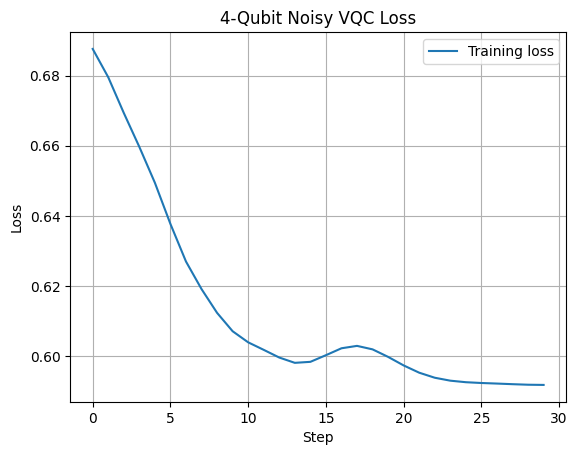

In [51]:
import matplotlib.pyplot as plt

dev = qml.device("default.mixed", wires=n_qubits, shots=None)

def noisy_feature_map(x):
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        qml.RZ(x[i], wires=i)
        qml.DepolarizingChannel(0.01, wires=i)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i+1])
        qml.DepolarizingChannel(0.02, wires=i+1)

@qml.qnode(dev)
def circuit(x, weights):
    noisy_feature_map(x)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

def model(x, w): return circuit(x, w)
def loss(w, X, y):
    return pnp.mean(pnp.log(1 + pnp.exp(-y * pnp.array([model(x, w) for x in X]))))

# Train with reduced qubits
weights = pnp.array(0.01 * np.random.randn(3, n_qubits, 3), requires_grad=True)
opt = qml.optimize.AdamOptimizer(stepsize=0.1)
losses = []

print(" Training 4-qubit noisy VQC...")
for step in range(30):
    weights = opt.step(lambda w: loss(w, X_train_small, y_train), weights)
    l = loss(weights, X_train_small, y_train)
    losses.append(l)
    print(f"[{step:02d}] Loss: {l:.4f}")

# Evaluate
y_pred = [1 if model(x, weights) > 0 else -1 for x in X_test_small]
acc = np.mean(y_pred == y_test)
print(f"\n Test Accuracy (4Q Noisy): {acc*100:.2f}%")

# Plot loss
plt.plot(losses, label="Training loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("4-Qubit Noisy VQC Loss")
plt.grid(True)
plt.legend()
plt.show()